# Feasibility of Pseudo Double Source Plane Lenses (PDSPL)
### Author: Paras Sharma

This notebook simulates pseudo double source plane lenses and mainly tries to answer the following questions:

Given the number of expected lenses to be of order 100'000, how near-identical are pairs of lenses to look like, such that they can be used as a defacto double source plane lenses?

1. Perform a forecast of lenses with SLSim
2. Assess how close nearest-pairs of lenses are look-alike and how much scatter they introduce in their estimated mass.
3. Perform a forecast how pseudo double source plane lenses can constrain cosmology pretending them to be double source plane lenses with increased measurement uncertainties. You can use hierArc to run the forecast.


In [3]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
import numpy as np
import corner
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.lens import Lens
from slsim.image_simulation import lens_image, rgb_image_from_image_list
from slsim.Util.param_util import gaussian_psf

## Generate population of galaxies and (potential) deflectors

In [17]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# Generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=sky_area, filters=None, cosmo=cosmo
)

# Initiate deflector population class.
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light=None,
    cosmo=cosmo,
    sky_area=sky_area,
)

# Initiate source population class.
source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=sky_area,
    catalog_type="skypy",
)

# make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area,
)

# make lensplot class for extracting rgb images
gg_plot = LensingPlots(gg_lens_pop, num_pix=100, coadd_years=10)

print(f"LensPop initialized. Potential deflectors: {gg_lens_pop.deflector_number} ; Potential sources: {gg_lens_pop.source_number}");

LensPop initialized. Potential deflectors: 34963 ; Potential sources: 47365


/Users/paras/Codes/installed_repos/slsim/slsim/Deflectors/all_lens_galaxies.py:54: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/Users/paras/Codes/installed_repos/slsim/slsim/Deflectors/all_lens_galaxies.py:57: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


## Check the PDSPL properties with just two lenses

In [48]:
kwargs_lens_cut = {"min_image_separation": 2, "max_image_separation": 10}

# select two random lenses from the population
random_lens_class1 = gg_lens_pop.select_lens_at_random(**kwargs_lens_cut)
random_lens_class2 = gg_lens_pop.select_lens_at_random(**kwargs_lens_cut)

# get the source for each lens
source_class1 = random_lens_class1.source(index = 0) # since there is only one source per lens
source_class2 = random_lens_class2.source(index = 0)

# get the deflector for each lens
deflector_class1 = random_lens_class1.deflector
deflector_class2 = random_lens_class2.deflector

# lens system for each deflector + source pair
lens_class_D1S1 = random_lens_class1
lens_class_D2S2 = random_lens_class2
lens_class_D1S2 = Lens(
    source_class=source_class2,
    deflector_class=deflector_class1,
    cosmo=cosmo,
    los_class=random_lens_class1.los_class,
)
lens_class_D2S1 = Lens(
    source_class=source_class1,
    deflector_class=deflector_class2,
    cosmo=cosmo,
    los_class=random_lens_class2.los_class,
)

## making the lens images for all four systems

# load your psf kernel and transform matrix.
psf_kernel = gaussian_psf(fwhm=0.9, delta_pix=0.2, num_pix=41)

# let's set pixel to angle transform matrix.
transform_matrix = np.array([[0.2, 0], [0, 0.2]])

# These numbers come from some random dp0 cutout variance map. User can use their values.
bkg_std_i = (0.05774509,)  # i-band background noise
bkg_std_r = 0.03247451  # r-band background noise
bkg_std_g = 0.028600888  # g-band background noise

lens_pairs_list = [
    lens_class_D1S1,
    lens_class_D2S2,
    lens_class_D1S2,
    lens_class_D2S1,
]
lens_pairs_identifier_list = [
    "D1S1",
    "D2S2",
    "D1S2",
    "D2S1",
]

image_lists = []
rgb_images = []

for lens_class in lens_pairs_list:
    image_i = lens_image(
        lens_class=lens_class,
        band="i",
        mag_zero_point=27,  # lsst coadd images have zero point magnitude of 27.
        num_pix=100,
        psf_kernel=psf_kernel,
        transform_pix2angle=transform_matrix,
        exposure_time=300,  # one can provide None
        t_obs=None,
        std_gaussian_noise=bkg_std_i,  # one can provide None
        with_source=True,
        with_deflector=True,
    )
    image_r = lens_image(
        lens_class=lens_class,
        band="r",
        mag_zero_point=27,
        num_pix=100,
        psf_kernel=psf_kernel,
        transform_pix2angle=transform_matrix,
        exposure_time=300,
        t_obs=None,
        std_gaussian_noise=bkg_std_r,
        with_source=True,
        with_deflector=True,
    )

    image_g = lens_image(
        lens_class=lens_class,
        band="g",
        mag_zero_point=27,
        num_pix=100,
        psf_kernel=psf_kernel,
        transform_pix2angle=transform_matrix,
        exposure_time=300,
        t_obs=None,
        std_gaussian_noise=bkg_std_g,
        with_source=True,
        with_deflector=True,
    )

    image_list = [image_i, image_r, image_g]

    # Simulate rgb color image
    rgb_image = rgb_image_from_image_list(image_list, stretch=0.5)

    # Append the images to the list
    image_lists.append(image_list)
    rgb_images.append(rgb_image)

--------------------------------------------------
DEFLECTOR 1 PROPERTIES
 Redshift: 1.31
 Magnitude (i): 22.67
 Magnitude (r): 23.72
 Magnitude (g): 24.15
 Mass: 920253747956.6251 Msun
 Light Ellipticity (e1, e2): (-0.07074233728352863, 0.20538373215776778)
 Mass Ellipticity  (e1, e2): (-0.028037103479594566, 0.23279148614515943)
 Deflector Mass Model List: (['SIE', 'SHEAR', 'CONVERGENCE'], [{'theta_E': 1.1856106794064638, 'e1': 0.028037103479594566, 'e2': 0.23279148614515943, 'center_x': -0.12597599819403876, 'center_y': -0.10817050933761177}, {'gamma1': 0.004393761692531192, 'gamma2': 0.15871555978061247, 'ra_0': 0, 'dec_0': 0}, {'kappa': -0.04027118790172555, 'ra_0': 0, 'dec_0': 0}])
--------------------------------------------------
DEFLECTOR 2 PROPERTIES
 Redshift: 0.78
 Magnitude (i): 20.07
 Magnitude (r): 20.89
 Magnitude (g): 21.42
 Mass: 694790674970.9397 Msun
 Light Ellipticity (e1, e2): (0.292482091119243, -0.08017635308525807)
 Mass Ellipticity  (e1, e2): (0.39827981579166

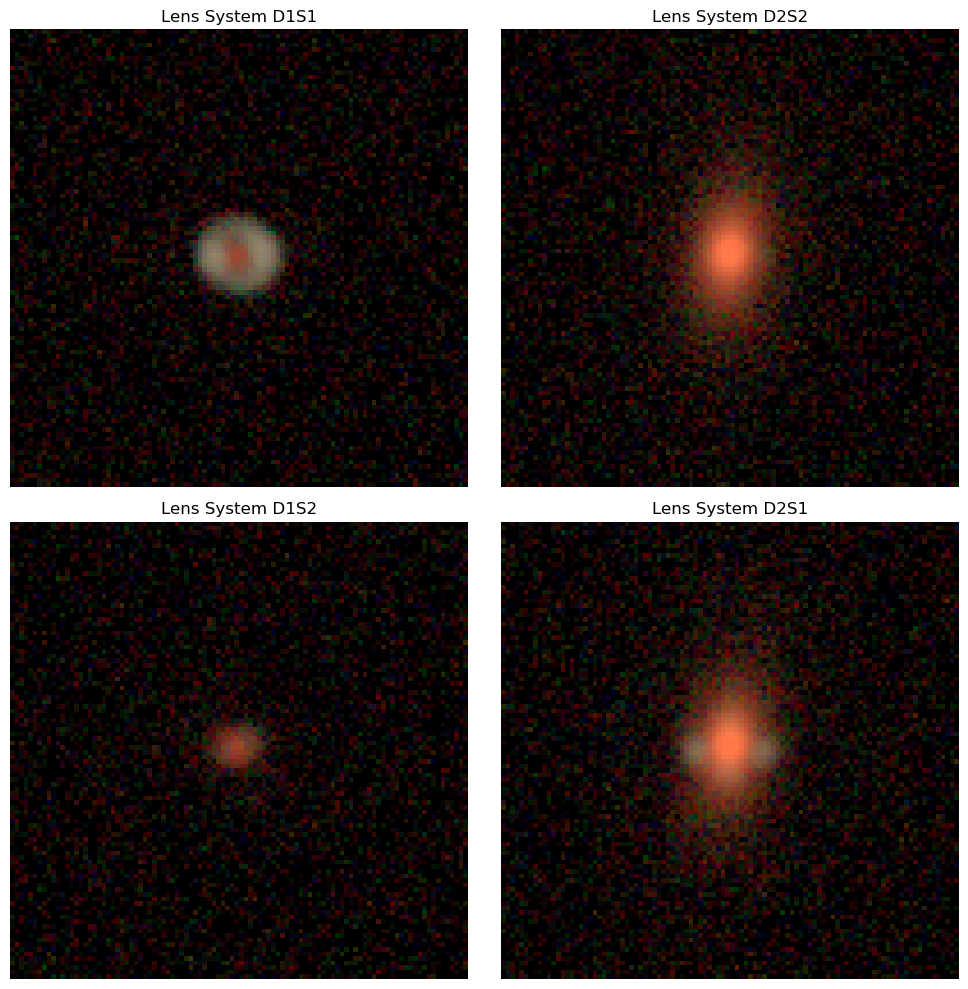

In [49]:
# print Deflector and Source properties
print("--"*25)
print(f"DEFLECTOR 1 PROPERTIES")
print(f" Redshift: {random_lens_class1.deflector_redshift:.2f}")
print(f" Magnitude (i): {random_lens_class1.deflector_magnitude('i'):.2f}")
print(f" Magnitude (r): {random_lens_class1.deflector_magnitude('r'):.2f}")
print(f" Magnitude (g): {random_lens_class1.deflector_magnitude('g'):.2f}")
print(f" Mass: {random_lens_class1.deflector_stellar_mass()} Msun")
print(f" Light Ellipticity (e1, e2): {random_lens_class1.deflector_ellipticity()[:2]}")
print(f" Mass Ellipticity  (e1, e2): {random_lens_class1.deflector_ellipticity()[2:]}")
print(f" Deflector Mass Model List: {random_lens_class1.deflector_mass_model_lenstronomy()}")

print("--"*25)
print(f"DEFLECTOR 2 PROPERTIES")
print(f" Redshift: {random_lens_class2.deflector_redshift:.2f}")
print(f" Magnitude (i): {random_lens_class2.deflector_magnitude('i'):.2f}")
print(f" Magnitude (r): {random_lens_class2.deflector_magnitude('r'):.2f}")
print(f" Magnitude (g): {random_lens_class2.deflector_magnitude('g'):.2f}")
print(f" Mass: {random_lens_class2.deflector_stellar_mass()} Msun")
print(f" Light Ellipticity (e1, e2): {random_lens_class2.deflector_ellipticity()[:2]}")
print(f" Mass Ellipticity  (e1, e2): {random_lens_class2.deflector_ellipticity()[2:]}")
print(f" Deflector Mass Model List: {random_lens_class2.deflector_mass_model_lenstronomy()}")

# print einstein radius for each deflector + source
print("--"*25)
print("--"*25)
print(f"ORIGINAL EINSTEIN RADIUS")
print(f" Deflector 1 + Source 1 (thetaE1): {random_lens_class1._einstein_radius(source_class1):.2f} arcsec")
print(f" Deflector 2 + Source 2 (thetaE2): {random_lens_class2._einstein_radius(source_class2):.2f} arcsec")
print("--"*25)
print(f"SWAPPED EINSTEIN RADIUS")
print(f" Deflector 1 + Source 2 (thetaE2_virtual): {random_lens_class1._einstein_radius(source_class2):.2f} arcsec")
print(f" Deflector 2 + Source 1 (thetaE1_virtual): {random_lens_class2._einstein_radius(source_class1):.2f} arcsec")
print("--"*25)
print(f"EINSTEIN RADIUS RATIO FOR PSEUDO DSPL")
print(f" Deflector 1: thetaE1/thetaE2_virtual = {random_lens_class1._einstein_radius(source_class1)/random_lens_class1._einstein_radius(source_class2):.2f}")
print(f" Deflector 2: thetaE1_virtual/thetaE2 = {random_lens_class2._einstein_radius(source_class1)/random_lens_class2._einstein_radius(source_class2):.2f}")

print("--"*25)


# image of the 4 lens systems along with axes labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, image in enumerate(rgb_images):
    ax[i // 2, i % 2].imshow(image)
    ax[i // 2, i % 2].set_title(f"Lens System {lens_pairs_identifier_list[i]}")
    ax[i // 2, i % 2].axis("off")
plt.tight_layout()

## Criteria for PDSPL lenses to be used as double source plane lenses

![PDSPL Illustration](pdspl_illustration.jpeg)

D1 and D2 differ in the following properties:
- **Redshift**: $\Delta z = z_{D1} - z_{D2}$
- **Mass**: $\Delta M = M_{D1} - M_{D2}$
- **Mass Model**: $\Delta M_{model} = M_{D1, model} - M_{D2, model}$
- **Light Model**: $\Delta L_{model} = L_{D1, model} - L_{D2, model}$
- **Size**: $\Delta R_{eff} = R_{eff, D1} - R_{eff, D2}$
- **Magnitude**: $\Delta m = m_{D1} - m_{D2}$ (for all bands)
- **Position?**:

We define:
$$\beta_{D1} = \frac{\theta_{E_1}}{\theta_{E_2, virtual}} \ \ \ \ \ \ \text{\&} \ \ \ \ \ \ \beta_{D2} = \frac{\theta_{E_1, virtual}}{\theta_{E_2}}$$

Thus our goal is to find the above $\Delta$ parameters that minimize the following:
$$|\Delta \beta| = |\beta_{D1} - \beta_{D2}|$$

Given N = 100,000 single source plane lenses, each lens has the parameters:
1. Redshift_D1, Redshift_S1
2. Mass_D1
3. Mass_Model_D1
4. Magnitudes_D1
5. Size_D1
6. Light_Model_D1
7. Light_Model_S1
8. Position_D1

we can generate N(N-1)/2 pairs of lenses. Each of these pairs will have the following differences:
- $\Delta$Redshift
- $\Delta$Mass
- $\Delta$Mass_Model
- $\Delta$Magnitude
- $\Delta$Size
- $\Delta$Light_Model
- $\Delta$Position

so the prior for the above parameters can be defined as:
$$P

Prior: 

## Generate the full population
We are using the instance of the LensPop() class to draw the full population within specified cuts in a Monte Carlo process.

In [8]:
# specifying cuts of the population
kwargs_lens_cuts = {"mag_arc_limit": {"g": 28}}
# drawing population
gg_lens_population = gg_lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cuts, multi_source=True)

## Represent key quantities of full population in corner plots
We calculate few key quantities of the lenses. The full population is represented each with a Lens() class

object that allows to compute and return these (and more) quantities.

In [9]:
print("Number of lenses:", len(gg_lens_population))

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in gg_lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius[0]
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift_list[0]
    source_mag = gg_lens.extended_source_magnitude(band="g", lensed=True)[0]
    deflector_mag = gg_lens.deflector_magnitude(band="g")
    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

Number of lenses: 34


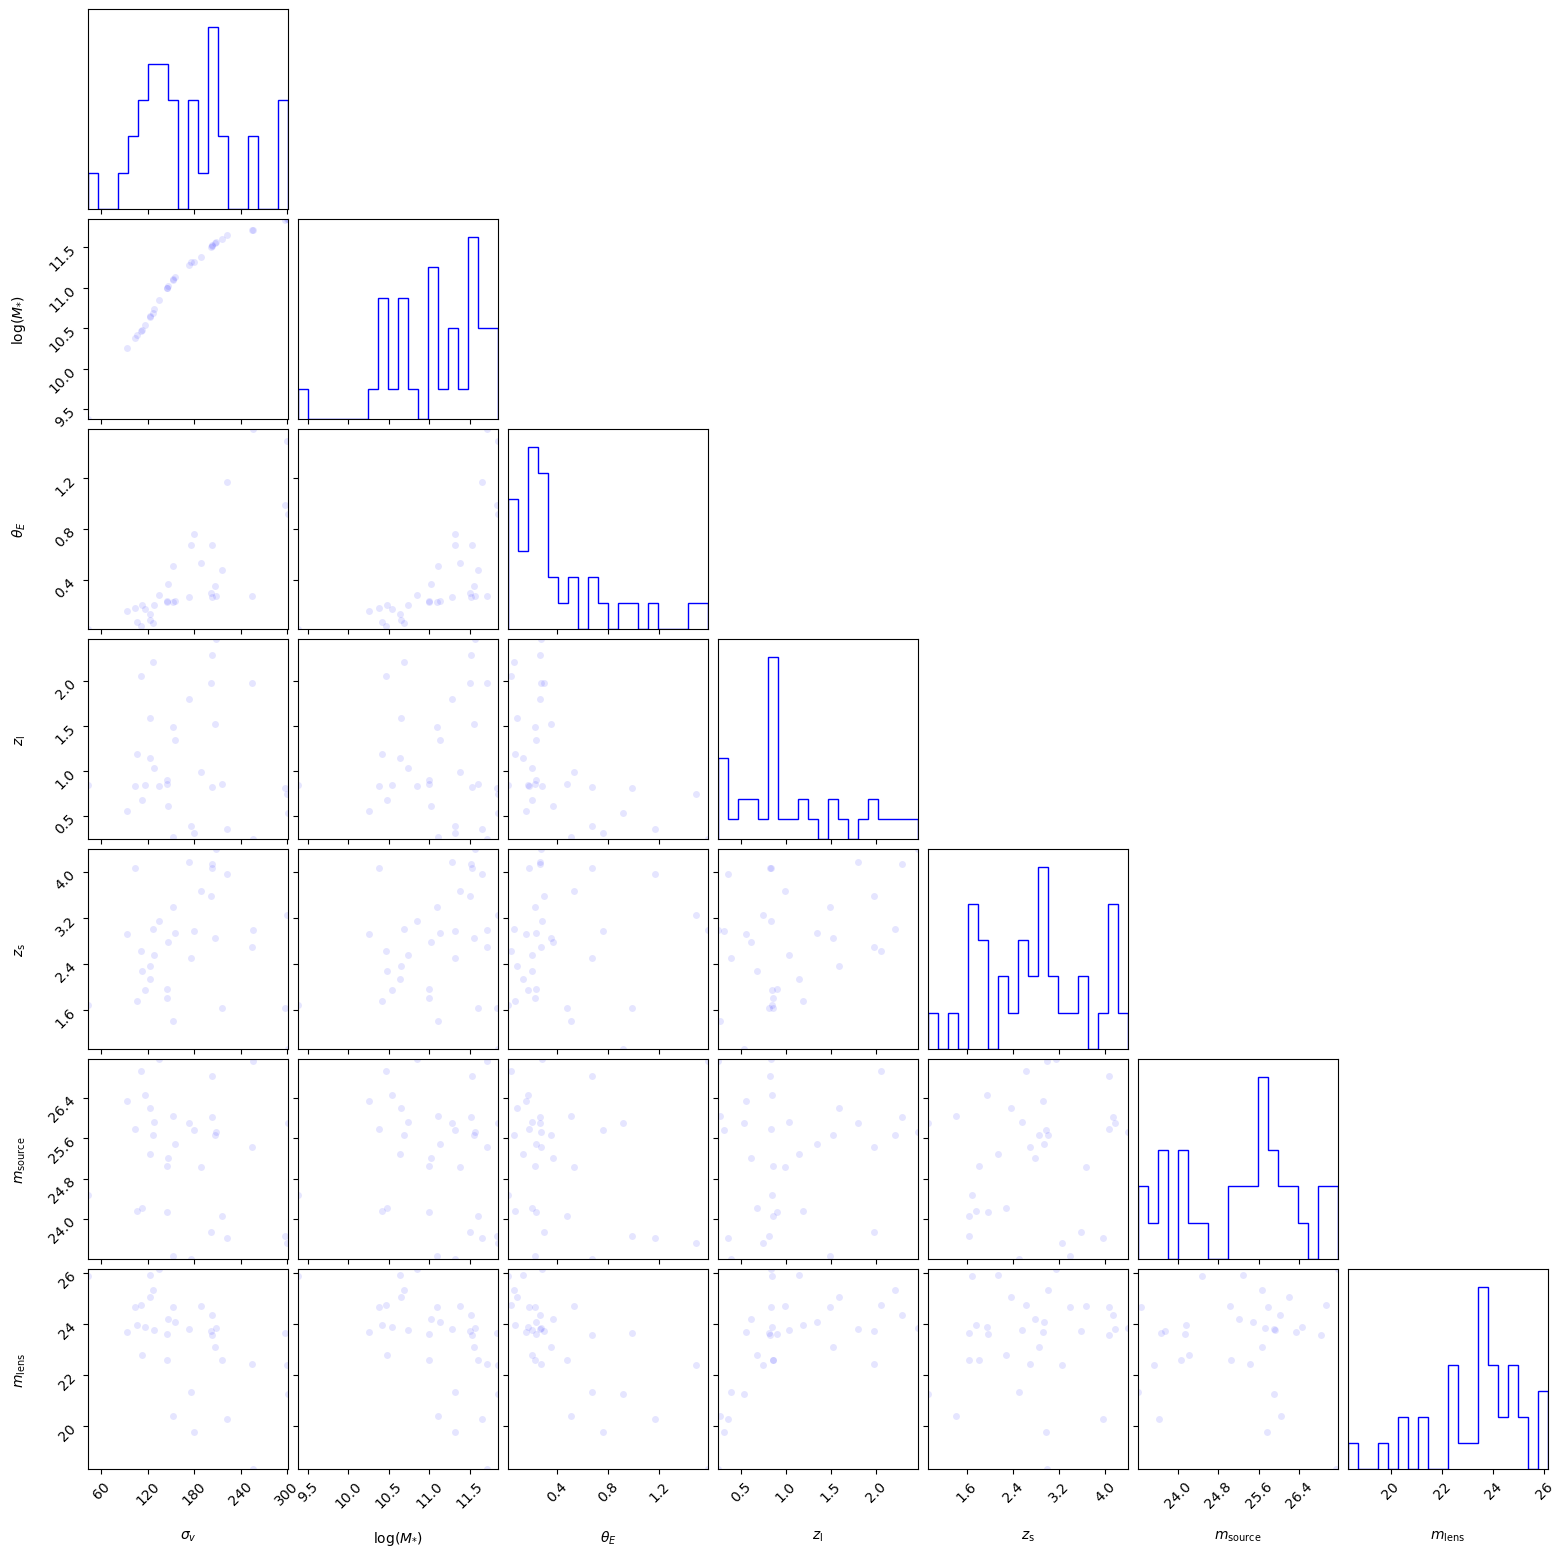

In [10]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()